In [1]:
import torch
from torch import nn
from transformers import AutoModel, AutoTokenizer
import random
from transformers import TrainingArguments, Trainer
import mlflow
from torchinfo import summary

random.seed(42)

In [2]:
embedder_name = 'google-bert/bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(embedder_name)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# Setting device on GPU if available
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
import pandas as pd
import os 

data_dir = '/home/ubuntu/TextStock/data/competition_data'
merged_data = pd.read_csv(os.path.join(data_dir, 'full_data.csv'), index_col=0)

In [5]:
merged_data.head()


,Date,Open,High,Low,Close,Volume,Adj Close,Label,Top1,Top2,...,headline_topic_0,headline_topic_1,headline_topic_2,headline_topic_3,headline_topic_4,headline_topic_5,headline_topic_6,headline_topic_7,headline_topic_8,headline_topic_9
1862,2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,11734.32031,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',...,0.077452,0.027559,0.089896,0.054157,0.137296,0.137123,0.227256,0.055558,0.134330,0.059373
1861,2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000,11782.34961,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',...,0.112519,0.106180,0.089383,0.037320,0.143491,0.097843,0.282645,0.042399,0.030168,0.058052
1860,2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000,11642.46973,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""",...,0.101699,0.028118,0.036736,0.081626,0.028117,0.111068,0.311158,0.107205,0.108571,0.085703
1859,2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000,11532.95996,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",...,0.066877,0.127792,0.065496,0.073997,0.123949,0.070983,0.184402,0.040296,0.134380,0.111827
1858,2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000,11615.92969,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,...,0.067761,0.053651,0.108737,0.069179,0.238253,0.028422,0.124376,0.117796,0.163402,0.028423


In [6]:
def add_lagged_feature(df, feature):
    # Calculate percentage change excluding the current day
    df['Lagged_' + feature] = df[feature].pct_change().shift(-1)
    df['Lagged_3_' + feature] = df['Lagged_' + feature].shift(3)
    df['Lagged_5_' + feature] = df['Lagged_' + feature].shift(5)
    df['Lagged_7_' + feature] = df['Lagged_' + feature].shift(7)
    return df

merged_data = add_lagged_feature(merged_data, 'Volume')

In [7]:
def add_price_change_features(df):
    df['Daily_range'] = df['High'] - df['Low']
    df['Prev_close_change'] = df['Close'].diff()
    df['Open_close_change'] = df['Close'] - df['Open']
    #df['close_prev_close_pct_change'] = df['close'].pct_change()
    return df

#merged_data = add_price_change_features(merged_data.copy())

In [8]:
def add_volume_features(df, window=10):
    # Calculate rolling mean excluding the current day
    df['Volume_rolling_mean'] = df['Volume'].rolling(window=window).mean().shift(1)
    df['Volume_change'] = df['Volume'].diff().shift(-1)    
    return df

merged_data = add_volume_features(merged_data.copy())

In [9]:
def add_volatility_features(df, window=10):
    # Calculate rolling standard deviation excluding the current day
    df['Rolling_std'] = df['Close'].rolling(window=window).std().shift(1)
    return df

merged_data = add_volatility_features(merged_data.copy())

/tmp/ipykernel_35100/800437326.py:16: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_35100/800437326.py:18: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




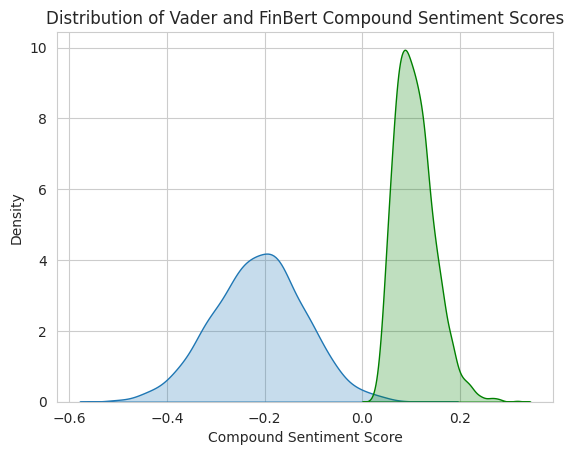

In [10]:
#Plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()

vader_compound = merged_data.vader_sentiment_compound
finbert_positive = merged_data.finbert_positive
finbert_negative = merged_data.finbert_positive


# Create a KDE plot of the compound sentiment scores
sns.kdeplot(vader_compound, shade=True, label='Vader')
#sns.kdeplot(finbert_negative, shade=True, label='FinBert neg',color='red')
sns.kdeplot(finbert_positive, shade=True, label='FinBert pos',color='green')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Vader and FinBert Compound Sentiment Scores')
plt.show()

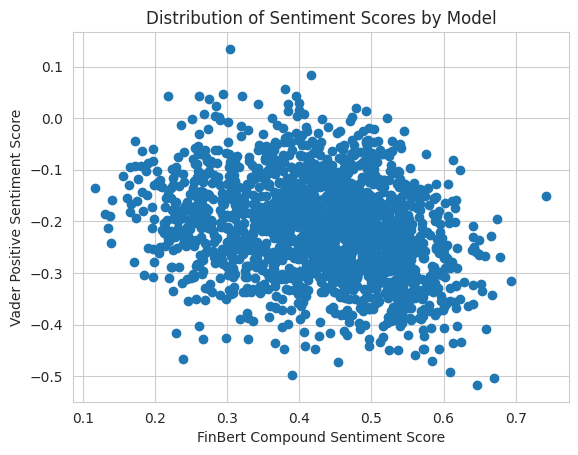

In [11]:
# Create a scatter plot using Matplotlib
plt.scatter(merged_data['finbert_negative'], merged_data['vader_sentiment_compound'])
plt.xlabel('FinBert Compound Sentiment Score')
plt.ylabel('Vader Positive Sentiment Score')
plt.title('Distribution of Sentiment Scores by Model')
plt.show()

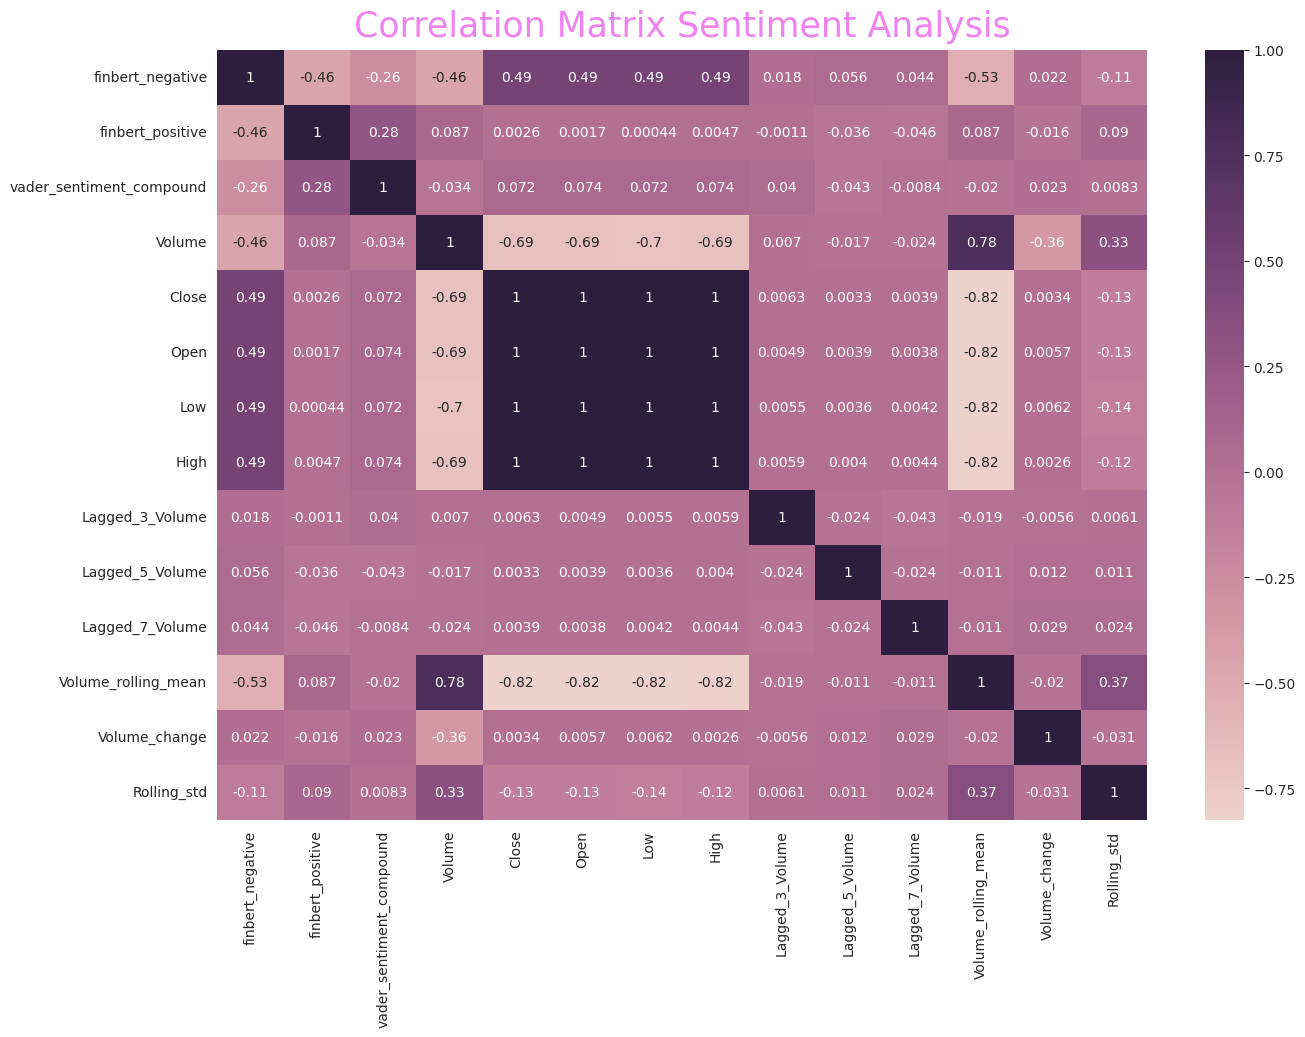

In [12]:
cm = merged_data[['finbert_negative','finbert_positive','vader_sentiment_compound', 'Volume', 'Close', 'Open', 'Low', 'High', 'Lagged_3_Volume', 'Lagged_5_Volume', 'Lagged_7_Volume', 'Volume_rolling_mean', 'Volume_change', 'Rolling_std']].copy()
plt.figure(figsize = (15,10))
sns.heatmap(cm.corr(), annot = True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Correlation Matrix Sentiment Analysis", fontsize = 25, color = 'violet', pad = 10, loc = 'center')
plt.show()

In [56]:
merged_data.dropna(inplace=True) # Remove rows with NaN due to shifting
assert len(merged_data[merged_data.isna().any(axis=1)]) == 0

In [57]:
numerical_columns = merged_data.select_dtypes(include=['number']).columns
numerical_columns = [_ for _ in numerical_columns if _ not in ['Label', 'Close', 'Adj Close']]
#financial_columns = ['Open', 'High', 'Low', 'Volume', 'Lagged_3_Volume', 'Lagged_5_Volume', 'Lagged_7_Volume']
financial_columns = ['Open', 'Volume_rolling_mean', 'Volume_change', 'Rolling_std']
topic_sent_columns = ['finbert_positive', 'finbert_negative', 'vader_sentiment_compound']
label_columns = ['Close']
numerical_columns, topic_sent_columns, financial_columns

(['Open',
  'High',
  'Low',
  'Volume',
  'finbert_positive',
  'finbert_negative',
  'finbert_neutral',
  'vader_sentiment_compound',
  'headline_topic_0',
  'headline_topic_1',
  'headline_topic_2',
  'headline_topic_3',
  'headline_topic_4',
  'headline_topic_5',
  'headline_topic_6',
  'headline_topic_7',
  'headline_topic_8',
  'headline_topic_9',
  'Lagged_Volume',
  'Lagged_3_Volume',
  'Lagged_5_Volume',
  'Lagged_7_Volume',
  'Volume_rolling_mean',
  'Volume_change',
  'Rolling_std'],
 ['finbert_positive', 'finbert_negative', 'vader_sentiment_compound'],
 ['Open', 'Volume_rolling_mean', 'Volume_change', 'Rolling_std'])

In [58]:
from sklearn.preprocessing import StandardScaler


train_ratio = 0.8

# Calculate split index
split_index = int(len(merged_data) * train_ratio)

# Split without shuffling
train_df = merged_data[:split_index]
y_train = train_df['Close']

valid_test_df = merged_data[split_index:]
valid_split_index = int(len(valid_test_df) * 0.5)
val_df = valid_test_df[:valid_split_index]
y_val = val_df['Close']

test_df = valid_test_df[valid_split_index:]
y_test = test_df['Close']

# Scale numerical features
scaler = StandardScaler()
train_df[financial_columns + label_columns] = scaler.fit_transform(train_df[financial_columns + label_columns])
val_df[financial_columns + label_columns] = scaler.transform(val_df[financial_columns + label_columns])
test_df[financial_columns + label_columns] = scaler.transform(test_df[financial_columns + label_columns])


In [60]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_headline_len):
        self.data = data
        self.max_headline_len = max_headline_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = row['Close']
        numerical_cols = financial_columns + topic_sent_columns
        market_data = self.data[numerical_cols].iloc[idx].values
        headlines = eval(row['unique_headlines'])
         # Tokenize headlines
        headline_tokens = self.tokenizer(headlines,
                                         padding='max_length',
                                         truncation=True,
                                         max_length=self.max_headline_len,
                                         return_tensors='pt')
        return {
            'input_ids': headline_tokens['input_ids'].squeeze(0),
            'attention_mask': headline_tokens['attention_mask'].squeeze(0),
            'market_data': torch.tensor(market_data, dtype=torch.float),
            'close_price': torch.tensor(label, dtype=torch.float)
            }


In [61]:
class HeadlineAggregator(nn.Module):
    def __init__(self, bert_output_dim, lstm_hidden_dim, num_layers=1, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size=bert_output_dim, hidden_size=lstm_hidden_dim, 
                            num_layers=num_layers, batch_first=True, 
                            bidirectional=bidirectional)
        self.bidirectional = bidirectional
        self.final_dim = lstm_hidden_dim * (2 if bidirectional else 1)
        
    def forward(self, headline_embeddings):
        # headline_embeddings: (batch_size, num_headlines, bert_output_dim)
        # Initialize hidden and cell states as news: depends if we think about news as independent or not
        
        h0 = torch.zeros(1, headline_embeddings.size(0), self.lstm.hidden_size).to(headline_embeddings.device)
        c0 = torch.zeros(1, headline_embeddings.size(0), self.lstm.hidden_size).to(headline_embeddings.device)
        
        # x shape: (batch, seq_len, input_dim), for a single day batch=1
        # We can handle batch of days if needed, here we assume 1 day for simplicity. 
        output, (h_n, c_n) = self.lstm(headline_embeddings, (h0, c0))
        h_n = h_n.to(headline_embeddings.device)
        if self.bidirectional:
            # For a single-layer bidirectional LSTM: h_n shape is (2, batch, hidden_dim)
            # Concatenate forward and backward
            final_state = torch.cat([h_n[-2], h_n[-1]], dim=-1)  
        else:
            final_state = h_n[-1]  # shape: (batch, hidden_dim)
        #aggregated_embedding = output[:, -1, :] # (batch_size, lstm_hidden_dim)
        return final_state  # shape: (batch, final_dim)

In [62]:
import torch.nn.functional as F

class AttentionAggregator(nn.Module):
    def __init__(self, bert_output_dim, attention_head_size=64, dropout_prob=0.2):
        super().__init__()
        self.attention_head_size = attention_head_size
        self.query = nn.Linear(bert_output_dim, attention_head_size)
        self.key = nn.Linear(bert_output_dim, attention_head_size)
        self.value = nn.Linear(bert_output_dim, attention_head_size)
        self.scale_factor = torch.sqrt(torch.tensor(attention_head_size, dtype=torch.float32))
        self.dropout = nn.Dropout(dropout_prob)


    def forward(self, headline_embeddings):
        # headline_embeddings: (batch_size, num_headlines, bert_output_dim)
        batch_size, num_headlines, bert_output_dim = headline_embeddings.size()

        # Linear transformations for query, key, and value
        Q = self.query(headline_embeddings)  # (batch_size, num_headlines, attention_head_size)
        K = self.key(headline_embeddings)    # (batch_size, num_headlines, attention_head_size)
        V = self.value(headline_embeddings)  # (batch_size, num_headlines, attention_head_size)

        # Calculate attention weights
        attention_scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale_factor  # (batch_size, num_headlines, num_headlines)
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch_size, num_headlines, num_headlines)
        attention_weights = self.dropout(attention_weights) # Apply dropout to attention weights

        # Calculate weighted sum of value vectors
        aggregated_embedding = torch.matmul(attention_weights, V)  # (batch_size, num_headlines, attention_head_size)

        # You might want to reduce the dimension further, e.g., by averaging or passing through a linear layer
        aggregated_embedding = aggregated_embedding.mean(dim=1) # (batch_size, attention_head_size)

        return aggregated_embedding

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim



class PricePredictor(nn.Module):
    def __init__(self, bert_model_name, lstm_hidden_dim, market_data_dim, predictor_lstm_hidden_dim, dropout_prob=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
        
        self.headline_aggregator = HeadlineAggregator(bert_output_dim=self.bert.config.hidden_size,
                                                      lstm_hidden_dim=lstm_hidden_dim)
        
        self.predictor_lstm = nn.LSTM(input_size=lstm_hidden_dim + market_data_dim, 
                                      hidden_size=predictor_lstm_hidden_dim,
                                      batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(predictor_lstm_hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_prob)
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask, market_data):
       
        batch_size, num_headlines, seq_len = input_ids.size()
        bert_output_dim = self.bert.config.hidden_size
       
        # Reshape for BERT processing 
        headline_input_ids_flat = input_ids.view(-1, seq_len) # (batch_size, num_headlines * seq_len)
        headline_attention_mask_flat = attention_mask.view(-1, seq_len) # (batch_size, num_headlines * seq_len)
        
        # Get BERT embeddings for each headline
        headline_embeddings = self.bert(headline_input_ids_flat, attention_mask=headline_attention_mask_flat).pooler_output #.last_hidden_state[:, 0, :]
        headline_embeddings = headline_embeddings.view(batch_size, num_headlines, bert_output_dim)
        
        # Aggregate headline embeddings using LSTM
        aggregated_headline_embedding = self.headline_aggregator(headline_embeddings)

        # Early fusion: Concatenate aggregated headline embedding and market data
        combined_features = torch.cat((aggregated_headline_embedding, market_data), dim=1)
        combined_features = self.relu(combined_features)
        combined_features = self.dropout(combined_features)

        combined_features = combined_features.unsqueeze(1) # Add sequence dimension for LSTM        
        lstm_out, _ = self.predictor_lstm(combined_features)
        prediction = self.fc(lstm_out[:, -1, :])
        return prediction.squeeze(1)

In [64]:
bert_model_name = 'google-bert/bert-base-uncased'
max_headline_len = 48
lstm_hidden_dim = 128
predictor_lstm_hidden_dim = 128
batch_size = 32
learning_rate = 1e-3
market_data_dim = len(financial_columns + topic_sent_columns) 
num_epochs = 50
attention_head_size = 64
weight_decay = 1e-5



In [65]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, explained_variance_score


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = root_mean_squared_error(labels, predictions)
    mse = mean_squared_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    return {"rmse": rmse, "mse": mse, 'r2': r2}

In [66]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    market_data = torch.stack([item['market_data'] for item in batch])
    close_prices = torch.stack([item['close_price'] for item in batch])

    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    padded_attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        'input_ids': padded_input_ids,
        'attention_mask': padded_attention_masks,
        'market_data': market_data,
        'close_price': close_prices
    }

train_dataset = NewsDataset(train_df, tokenizer, max_headline_len)
valid_dataset = NewsDataset(val_df, tokenizer, max_headline_len)
test_dataset = NewsDataset(test_df, tokenizer, max_headline_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, collate_fn=custom_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, collate_fn=custom_collate_fn)


In [67]:
# --- Initialize Model, Loss, and Optimizer ---
model = PricePredictor(bert_model_name, lstm_hidden_dim, market_data_dim, predictor_lstm_hidden_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Scheduler (CosineAnnealingLR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)  # T_max is the number of epochs

# optimizer = AdamW([
#     {'params': bert_model.parameters(), 'lr': 1e-5},
#     {'params': lstm.parameters(), 'lr': 1e-3},
# ])

In [68]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fin_experiment_hierarchical')
#mlflow.set_tracking_uri(aws_instance_url)


In [69]:
# --- Training Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
accumulation_steps = 4


def train():
    model.train()
    best_val_loss = float('inf')
    patience = 3  # Number of epochs to wait for improvement
    trigger_times = 0

    for epoch in range(num_epochs):
        total_loss = 0
        running_loss = 0.0

        all_predictions = []
        all_labels = []
        for i, batch in enumerate(train_loader):
            model.train()
            headline_input_ids = batch['input_ids'].to(device)
            headline_attention_mask = batch['attention_mask'].to(device)
            market_data = batch['market_data'].to(device)
            close_price = batch['close_price'].to(device)
        
            optimizer.zero_grad()
            predictions = model(headline_input_ids, headline_attention_mask, market_data)
            all_labels.extend(close_price.cpu().detach().numpy())
            all_predictions.extend(predictions.cpu().detach().numpy())
            loss = criterion(predictions, close_price)
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()
            
            total_loss += loss.item()
            running_loss += loss.item()

            #if i % 10 == 9:
                # ...log the running loss
                #writer.add_scalar('training loss',
                #                running_loss / 10,
                #                   epoch * len(train_loader) + i)
                #mlflow.log_metric("training loss", f"{running_loss:3f}", step=(i // 10))
            
        # Eval after each epoch
        val_loss = model_eval()
        current_lr = scheduler.get_last_lr()[0]
        print(f"Current Learning Rate: {current_lr}")
        scheduler.step()
        rmse = root_mean_squared_error(all_labels, all_predictions)
        r2 = r2_score(all_labels, all_predictions)
        avg_loss = total_loss / len(train_loader)
        print(f"TRAIN: Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, RMSE: {rmse}, R2: {r2}")
        mlflow.log_metric("training loss", f"{avg_loss:.3f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pth') # Save the best model
        else:
            trigger_times += 1
            print(f"No improvement in validation loss for {trigger_times} epoch(s)")
            if trigger_times >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!")
                break
    
    print(f"Loading best model with validation loss: {best_val_loss:.4f}")
    model.load_state_dict(torch.load('best_model.pth')) # Load the best model weights
    

# --- Evaluation ---
def model_eval():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for i, batch in enumerate(valid_loader):
            headline_input_ids = batch['input_ids'].to(device)
            headline_attention_mask = batch['attention_mask'].to(device)
            market_data = batch['market_data'].to(device)
            close_price = batch['close_price'].to(device)
            predictions = model(headline_input_ids, headline_attention_mask, market_data)
            all_labels.extend(close_price.cpu().detach().numpy())
            all_predictions.extend(predictions.cpu().detach().numpy())
            loss = criterion(predictions, close_price)
            test_loss += loss.item()

            writer.add_scalar('valid loss', loss)
    
    rmse = root_mean_squared_error(all_labels, all_predictions)
    r2 = r2_score(all_labels, all_predictions)
    avg_test_loss = test_loss / len(valid_loader)
    print(f"TEST: Loss: {avg_test_loss:.4f}, RMSE: {rmse}, R2: {r2}")
    mlflow.log_metric("validation loss", f"{avg_test_loss:.3f}")
    return avg_test_loss


In [71]:
def model_inference(headline, market_data, tokenizer, model, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculations for inference
        # Tokenize the headline
        encoded_input = tokenizer(headline, padding=True, truncation=True, return_tensors='pt')
        headline_input_ids = encoded_input['input_ids'].to(device)
        headline_attention_mask = encoded_input['attention_mask'].to(device)

        # Convert market_data to a tensor
        market_data_tensor = torch.tensor(market_data).unsqueeze(0).to(device)  # Assuming 1D array for single example

        # Get model predictions
        predictions = model(headline_input_ids, headline_attention_mask, market_data_tensor)
        
        # Convert predictions to numpy array
        predicted_close_price = predictions.cpu().detach().numpy()
        
        return predicted_close_price


In [ ]:
mlflow.set_experiment("MLflow Price Predict New Run #9")

with mlflow.start_run():
    params = {
        "epochs": num_epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "loss_function": criterion.__class__.__name__,
        "optimizer": "Adam",
    }
    mlflow.log_params(params)
    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")
    train()

In [44]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

model.eval()
with torch.no_grad():
    all_valid_predictions = []
    all_valid_labels = []
    for i, batch in enumerate(valid_loader):
        headline_input_ids = batch['input_ids'].to(device)
        headline_attention_mask = batch['attention_mask'].to(device)
        market_data = batch['market_data'].to(device)
        close_price = batch['close_price'].to(device)
        predictions = model(headline_input_ids, headline_attention_mask, market_data)
        all_valid_labels.extend(close_price.cpu().detach().numpy())
        all_valid_predictions.extend(predictions.cpu().detach().numpy())


In [45]:
with torch.no_grad():
    all_train_predictions = []
    all_train_labels = []
    for i, batch in enumerate(train_loader):
        headline_input_ids = batch['input_ids'].to(device)
        headline_attention_mask = batch['attention_mask'].to(device)
        market_data = batch['market_data'].to(device)
        close_price = batch['close_price'].to(device)
        predictions = model(headline_input_ids, headline_attention_mask, market_data)
        all_train_labels.extend(close_price.cpu().detach().numpy())
        all_train_predictions.extend(predictions.cpu().detach().numpy())

In [46]:
with torch.no_grad():
    all_test_predictions = []
    all_test_labels = []
    for i, batch in enumerate(test_loader):
        headline_input_ids = batch['input_ids'].to(device)
        headline_attention_mask = batch['attention_mask'].to(device)
        market_data = batch['market_data'].to(device)
        close_price = batch['close_price'].to(device)
        predictions = model(headline_input_ids, headline_attention_mask, market_data)
        all_test_labels.extend(close_price.cpu().detach().numpy())
        all_test_predictions.extend(predictions.cpu().detach().numpy())

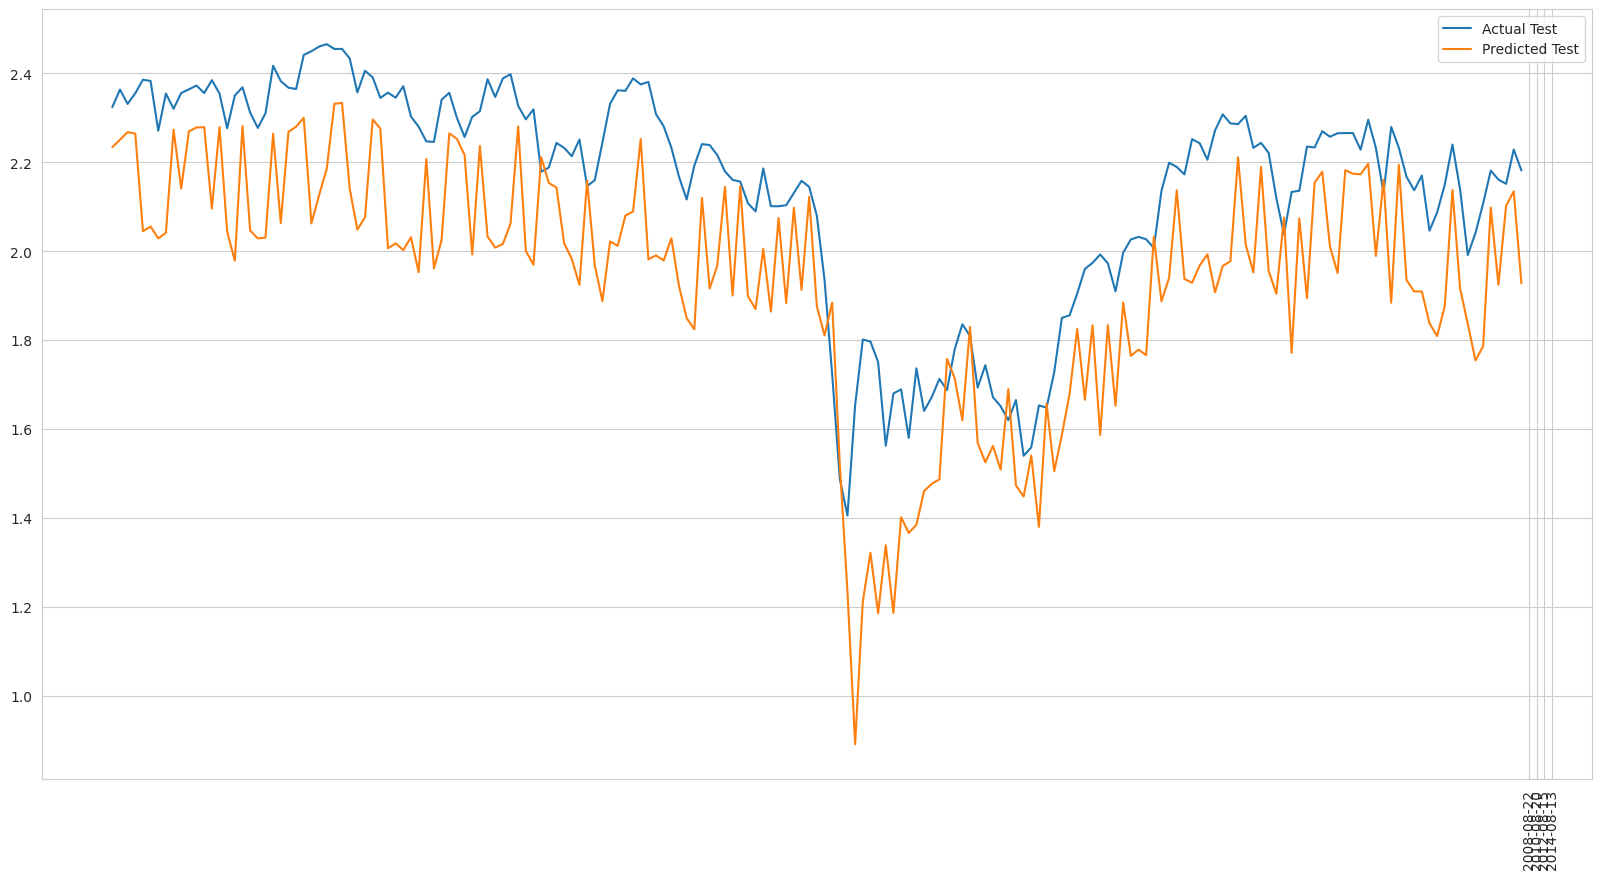

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
dates = merged_data['Date'].values
sampleInterval = 500
sampledDates = dates[::sampleInterval]

plt.figure(figsize=(20, 10))
# plt.plot(dates[:len(train_df)], train_df['Close'], label='Actual Train')
# plt.plot(dates[:len(train_df)], all_train_predictions, label='Predicted Train')
# plt.plot(dates[len(train_df):len(train_df) + len(val_df)], val_df['Close'], label='Actual Valid')
# plt.plot(dates[len(train_df):len(train_df) + len(val_df)], all_valid_predictions, label='Predicted Valid')
plt.plot(dates[len(train_df) + len(val_df):len(train_df) + len(test_df) + len(val_df) + len(test_df)], test_df['Close'], label='Actual Test')
plt.plot(dates[len(train_df) + len(val_df):len(train_df) + len(test_df) + len(test_df)], all_test_predictions, label='Predicted Test')

plt.xticks(sampledDates, rotation=90)

plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
dates = merged_data['Date'].values
sampleInterval = 60
sampledDates = dates[::sampleInterval]

plt.figure(figsize=(20, 10))
plt.plot(dates[:len(train_df)], train_df['Close'], label='Actual Train')
plt.plot(dates[:len(train_df)], all_train_predictions, label='Predicted Train')
plt.plot(dates[len(train_df):len(train_df) + len(val_df)], val_df['Close'], label='Actual Test')
plt.plot(dates[len(train_df):len(train_df) + len(val_df)], all_test_predictions, label='Predicted Test')

plt.xticks(sampledDates, rotation=90)

plt.legend()
plt.show()